# Simulation Pipeline for Hydrogen Simulation

In [1]:
# Simulation Imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import StatevectorSimulator

from qiskit.quantum_info import Operator, Statevector
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram


# Internal Imports
from util import generateHamiltonian, getBuilderByType, generatePhaseEstimation


## Simplified Run Pipeline

In [2]:
# Constants
theta = [-1.5960928412985012, 0.3554257493027984, 0.34119476657602105, -0.4854856102628099, 0.3554257493027984, 0.24586610112367618, 0.35255281608639216, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795, 0.24586610112367618, -0.4854856102628099, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795]
builderType = "Physical" # Options: Physical, Double Spin, Steane, Heterogenous Surface
num_of_shots = 1024
num_of_QPE_ancilla = 6
dt = 1

sim = StatevectorSimulator()

QiskitError: 'StatePreparation parameter vector has 16 elements, therefore expects 4 qubits. However, 8 were provided.'

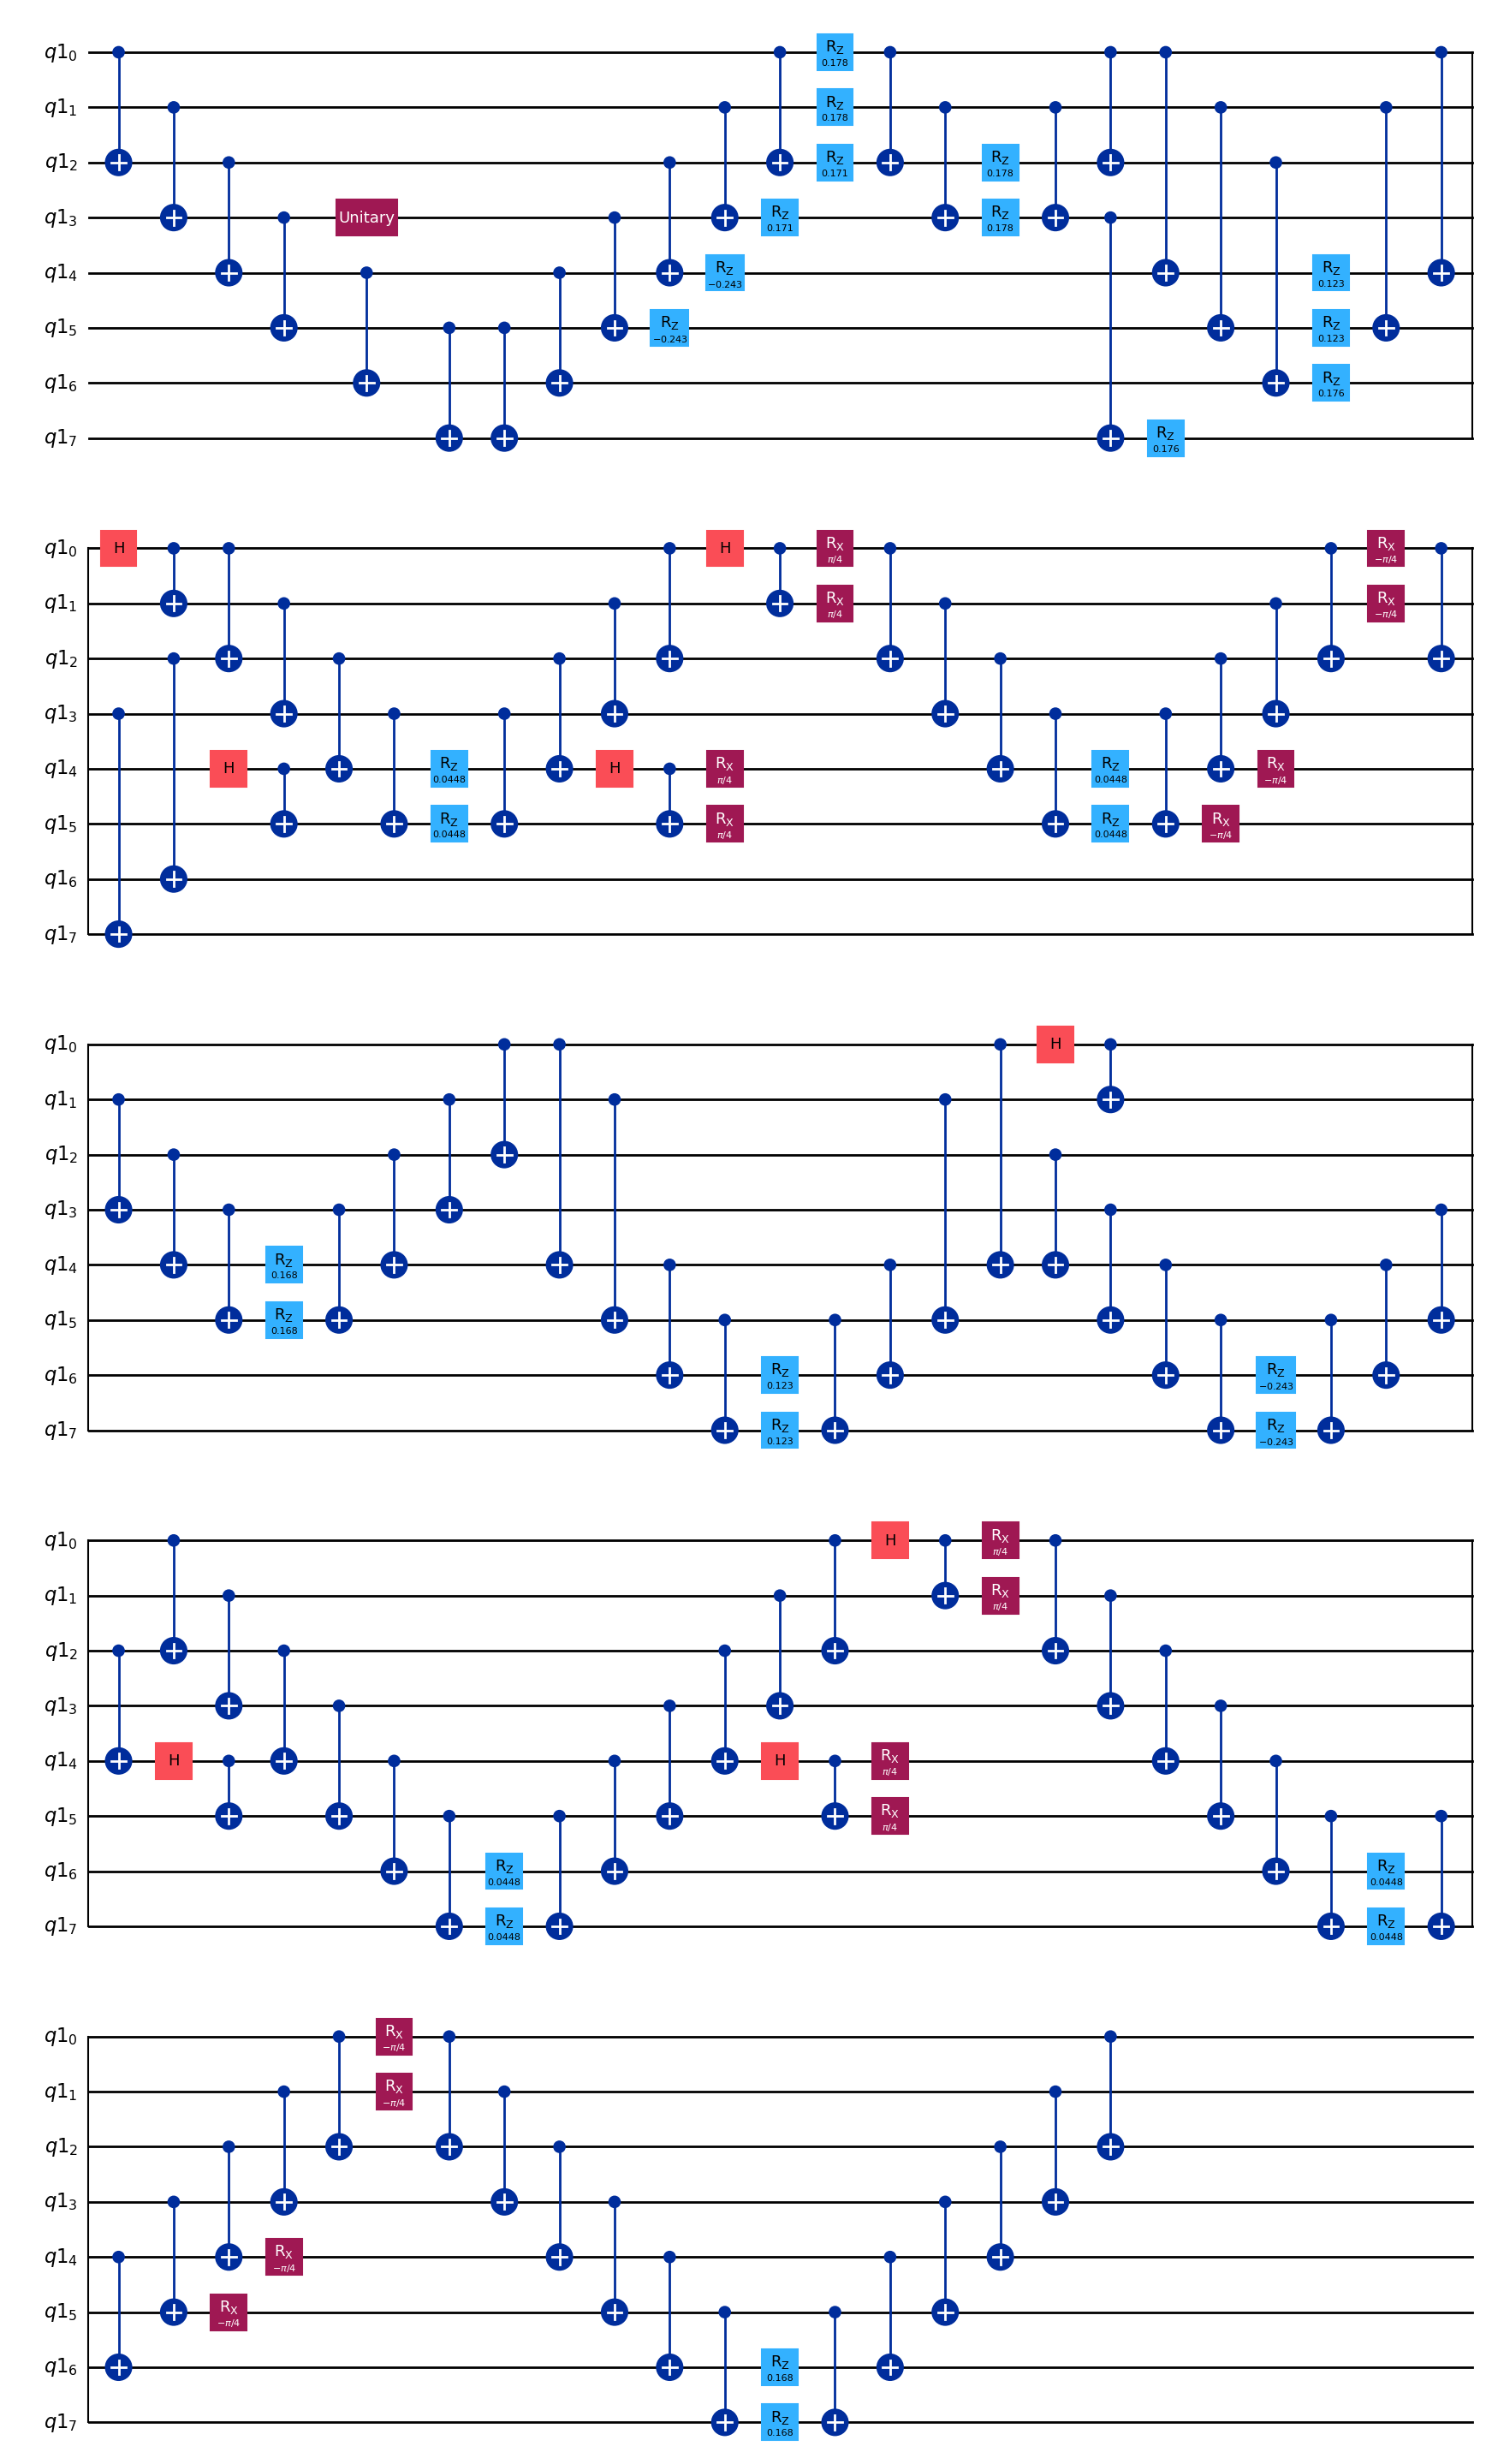

In [3]:
# Build the Circuit
hamiltonianBuilder = generateHamiltonian(theta, getBuilderByType(builderType))
plt.figure(hamiltonianBuilder.build().draw(output="mpl"))
initial_state =  Statevector([0. + 0.j, 1. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j],
                                    dims=(2, 2, 2, 2))
totalBuilder =  generatePhaseEstimation(num_of_QPE_ancilla, hamiltonianBuilder.getPhysicalNumber(), dt, hamiltonianBuilder.build(), initial_state)

{'100101': 1, '100000': 3, '110110': 1, '001111': 3, '111101': 1, '101101': 1, '011011': 1, '000000': 1, '000100': 1, '100100': 1, '011000': 7, '011010': 3, '000001': 1, '001010': 1, '011100': 1, '001101': 3, '010111': 3, '010101': 21, '001011': 1, '011101': 1, '000110': 2, '100011': 1, '010110': 10, '100001': 1, '010000': 7, '011001': 2, '010001': 17, '010100': 96, '010011': 792, '000010': 8, '010010': 32}
Most Frequent Result: 010011


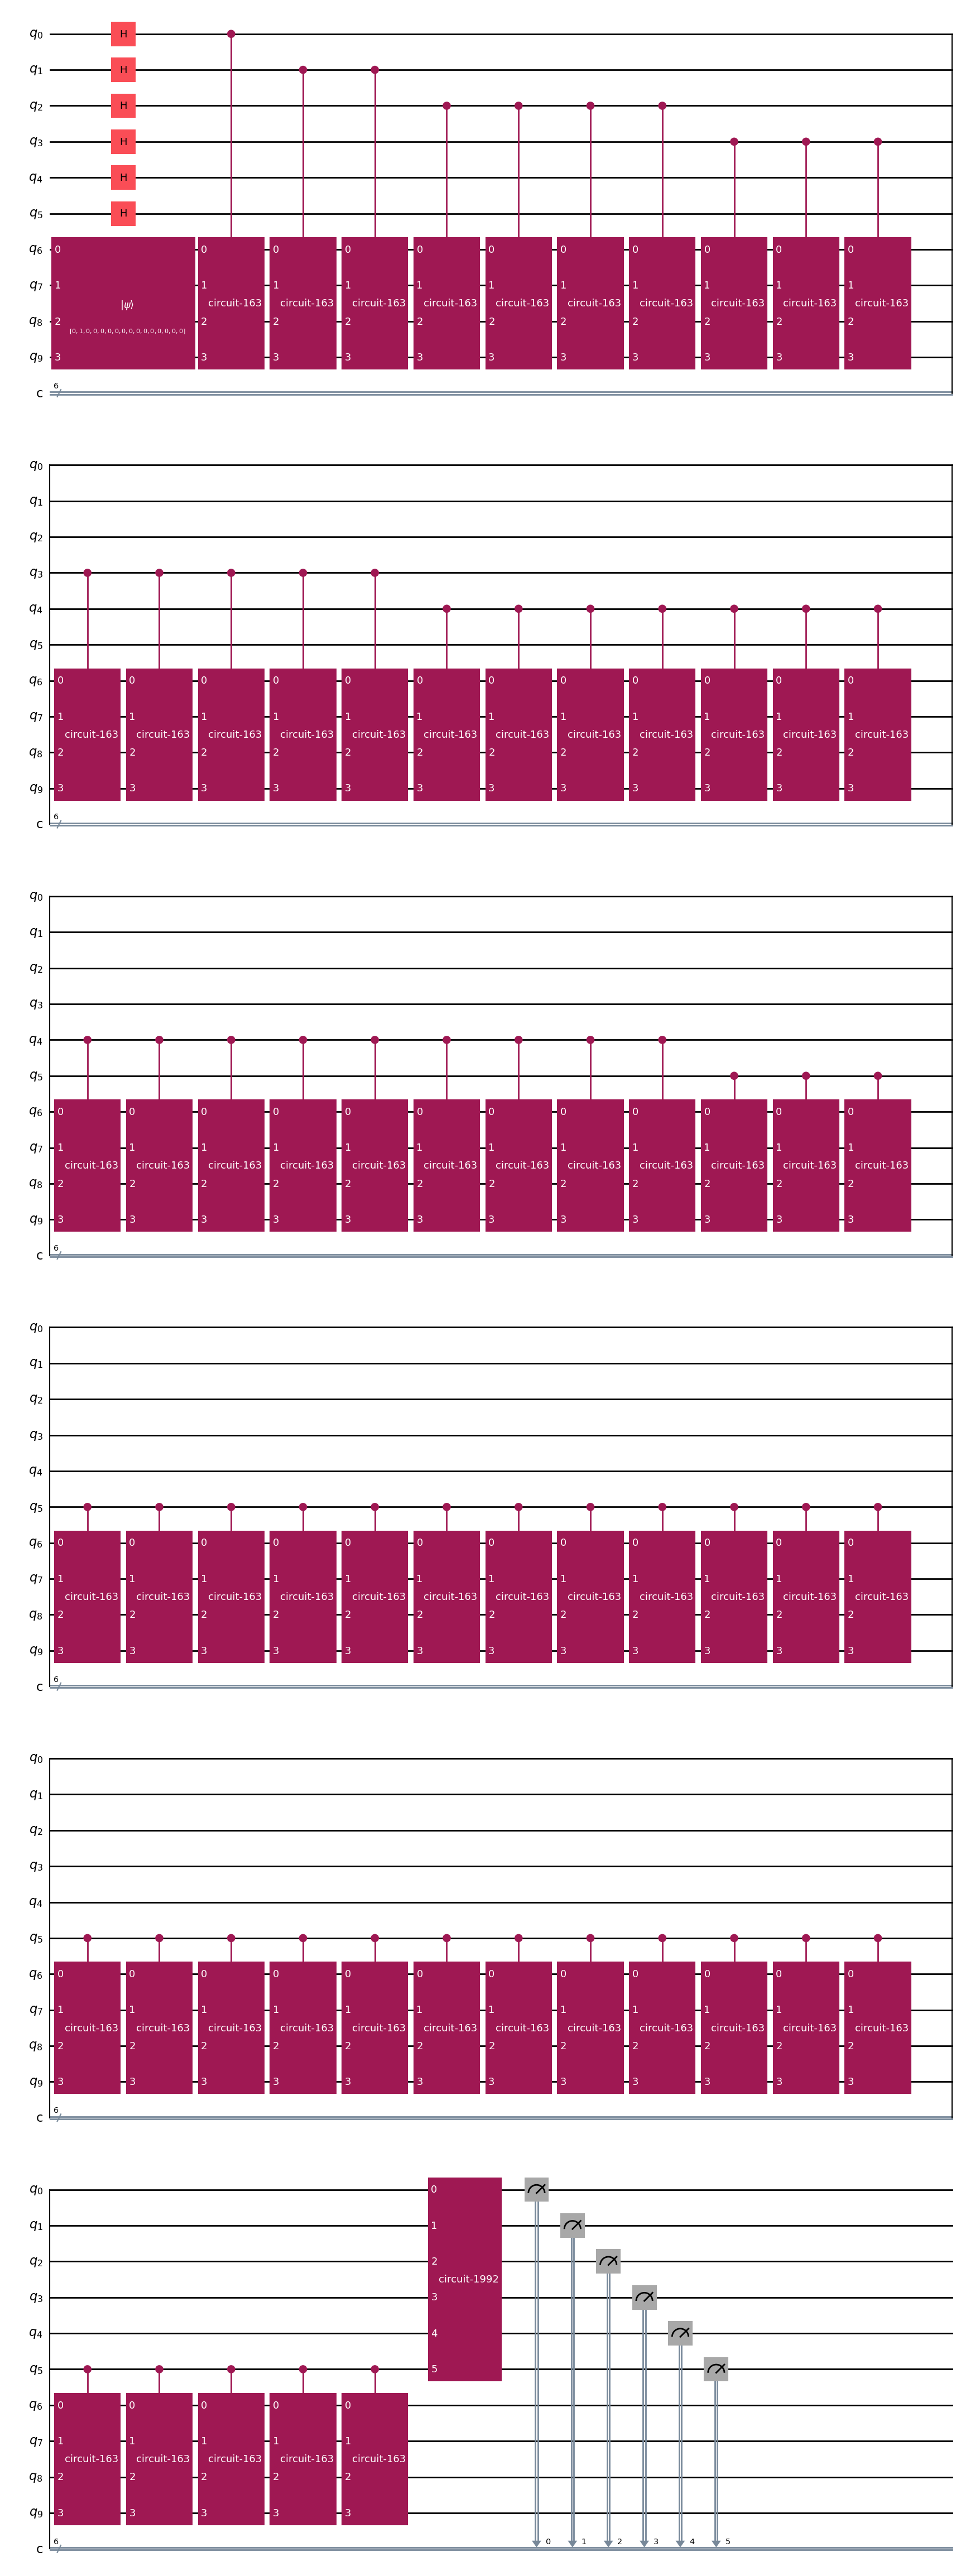

In [ ]:
# Run the Simulation
circuit = totalBuilder.build()
# Measure the ancilla qubits
circuit.measure(range(num_of_QPE_ancilla), range(num_of_QPE_ancilla))
plt.figure(circuit.draw(output="mpl"))
compiled = transpile(circuit, sim)
job = sim.run(compiled, shots=num_of_shots)
result = job.result()
counts = result.get_counts()
most_frequent_result = max(counts.items(), key=lambda x: x[1])[0]
print(counts)
print(f"Most Frequent Result: {most_frequent_result}")


## Vizualization of Results

### Ground State Energy

### Circuit Fidelity

### Statistical Invalid Codestate Detection

### Physical Gate Counts depending on encoding / computation time